<a href="https://colab.research.google.com/github/iEpsilon-FPS/QU-MLinF/blob/master/5.2%20Building_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Module: Data Science in Finance, Machine Learning in 30 minutes!
# Version 2.0
# Topic : Building models
# Example source: https://www.kaggle.com/wendykan/lending-club-loan-data
#####################################################################
# For support or questions, contact QuantUniversity at
# info@qusandbox.com
# Copyright 2020 QuantUniversity LLC.
#####################################################################

# Building models

This notebook deals with understanding the lending data obtained from https://www.kaggle.com/wendykan/lending-club-loan-data. We will cluster the data using K-Means clustering to see patterns in the dataset.

# Contents

* Imports
* Exploring the data
    * Dataset
    * Numerical and Categorical Features
* Preparing the data
    * Normalizing the data
    * Randomizing the data
    * Train-Test split
* Metrics for Regression
    * RMSE
    * MAE
    * MAPE
* Machine Learning Models
    * Linear Regression
    * Random Forest
    * Neural Network Regressor
* Comparing model performance
* Making predictions
* Saving the model


## Imports

In [ ]:
# for numerical analysis and data processing
import numpy as np
import pandas as pd
import itertools

from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

# for Machine learning algorithms
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.spatial.distance import cdist

# for vizualizations
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import requests
from io import StringIO

# Exploring the Data

## Dataset

The data set is the lending data for lendingclub from August 2011 to December 2011 for some borrowers. The feature descriptions for the data are also provided. Not all the features are required for making predictions, some features are redundant in the original data file. The provided data file is already cleaned and only relevant features are provided. There are two types of features, numerical and categorical.

Reading the input data from csv file.

In [ ]:
orig_url_data='https://drive.google.com//file//d//1yG-JxC1Br3c8u3cfmKQWC9pgz6Pqggw5//view?usp=sharing'
file_id = orig_url_data.split('//')[-2]
dwn_url='https://drive.google.com//uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
df = pd.read_csv(csv_raw)

orig_url_description='https://drive.google.com//file//d//1HFd4gKbknC28rHTWysec48NqfB6g3ZHx//view?usp=sharing'
file_id = orig_url_description.split('//')[-2]
dwn_url='https://drive.google.com//uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
df_description = pd.read_excel(dwn_url)


del df['issue_d'] # removing issue date as it wont affect the prediction (redundant feature)

## Numerical and Categorical features

In [ ]:
numeric_columns = df.select_dtypes(include=['float64','int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    df[col] = df[col].astype('category')

In [ ]:
numeric_columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'loan_status_Binary'],
      dtype='object')

In [ ]:
categorical_columns

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'purpose', 'addr_state'],
      dtype='object')

In [ ]:
p_categories = df['purpose'].cat.categories.tolist()
s_categories = df['addr_state'].cat.categories.tolist()
df[categorical_columns] = df[categorical_columns].apply(lambda x: x.cat.codes)

Storing interest rate statistics which will be used later for inference. 

In [ ]:
min_rate= df['int_rate'].min()
max_rate= df['int_rate'].max()
print(min_rate, max_rate, max_rate- min_rate)

5.42 24.11 18.689999999999998


# Preparing the dataset 

#### Normalizing the data
Normalize the data set for ease of calculations so that all features have values between 0 and 1.

In [ ]:
df=(df-df.min())/(df.max()-df.min())

#### Randomizing the data
Randomize the dataset so that any ordered patterns dont influence the prediction. (We have already skipped date as an influencing factor)

In [ ]:
df = df.iloc[np.random.permutation(len(df))]

#### Train-test split
The data is split into training and testing data. x represents the input features whereas y represents the output i.e. the interest rate.As a rule of thumb, we split the data into 80% training data and 20% testing or validation data.

In [ ]:
y = df.iloc[:,df.columns.isin(["int_rate"])]
x = df.loc[:, ~df.columns.isin(["int_rate"])]

total_samples=len(df)
split = 0.8

x_train = x[0:int(total_samples*split)]
x_test = x[int(total_samples*split):total_samples]
y_train = y[0:int(total_samples*split)]
y_test = y[int(total_samples*split):total_samples]

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    '''
    Calculates mean absolute error of the true and predicted values.
    '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    count = 0
    sum = 0
    for a, p in zip(y_true, y_pred):
        if(a!=0):
            sum+=(abs(a-p)/a)
            count+=1
    return (sum/count) * 100

In [ ]:
def view_metrics(y_test, predictions, algorithm, samples, total_samples):
    '''
    Plots the true and predicted values and prints RMS, MAE and MAPE metrics.
    '''
    fig = plt.figure(figsize=(18,5))
    plt.scatter(x=[i for i in range(samples)], y=[x for x in predictions[0:samples]], label='Predicted values')
    plt.scatter(x=[i for i in range(samples)], y=[x[0] for x in y_test.values[0:samples]], label='True values')
    plt.title('True and Predicted values for test dataset - %s' % algorithm)
    plt.legend()
    plt.show()
    
#     fig = plt.figure(figsize=(18,5))
#     plt.scatter(x=[i for i in range(total_samples)], y=[x for x in predictions], label='Predicted values')
#     plt.scatter(x=[i for i in range(total_samples)], y=[x[0] for x in y_test.values], label='True values')
#     plt.title('True and Predicted values for test dataset - %s' % algorithm)
#     plt.legend()
#     plt.show()

    RMS =  np.sqrt(mean_squared_error(y_test, predictions, multioutput='raw_values'))
    MAE = mean_absolute_error(y_test, predictions, multioutput='raw_values')
    MAPE = mean_absolute_percentage_error(y_test, predictions)
    print("Root Mean Squared Error:", RMS)
    print("Mean Absolute Error", MAE) 
    print("Mean Absolute Percentage Error", MAPE)
    return RMS, MAE, MAPE

### Metrics for regression models

#### Root Mean Squared Error
It represents the sample standard deviation of the differences between predicted values and observed values.

![alt text](https://docs.google.com/uc?export=download&id=1s3hjviNPw0iHzxKwwRWjOuecKPMxzWdZ)

#### Mean Absolute Error
MAE is the average of the absolute difference between the predicted values and observed value. The MAE is a linear score which means that all the individual differences are weighted equally in the average.

![alt text](https://docs.google.com/uc?export=download&id=1ZS3p1gNSdYrc_-2riw2OJ8o9UxUwXkX5)

#### Mean Absolute Percent Error
MAPE measures the size of the error in percentage terms. It is calculated as the average of the unsigned percentage error.

![alt text](https://docs.google.com/uc?export=download&id=1NrGo6q4JPDcatwdgKaqTVtqH5CavoXXL)

# Machine Learning Models

### Linear Regression

In [ ]:
lin_reg_model = LinearRegression() # build model
lin_reg_model= lin_reg_model.fit(x_train, y_train) # train model
R2 = lin_reg_model.score(x_train, y_train) # coefficient of determination
print(lin_reg_model.coef_)

[[ 1.18195377e-02  1.68896114e-03 -2.37924116e-02  2.64350428e-03
   1.07705478e+00  7.67255991e-04  6.80291037e-03 -5.48823568e-02
   2.92105052e-03 -8.20269137e-03 -3.32387467e-04  7.49232316e-03
   1.62601333e-02  3.10332374e-02 -1.41359087e-03]]


In [ ]:
lin_reg_model_predictions = lin_reg_model.predict(x_test) # make predictions

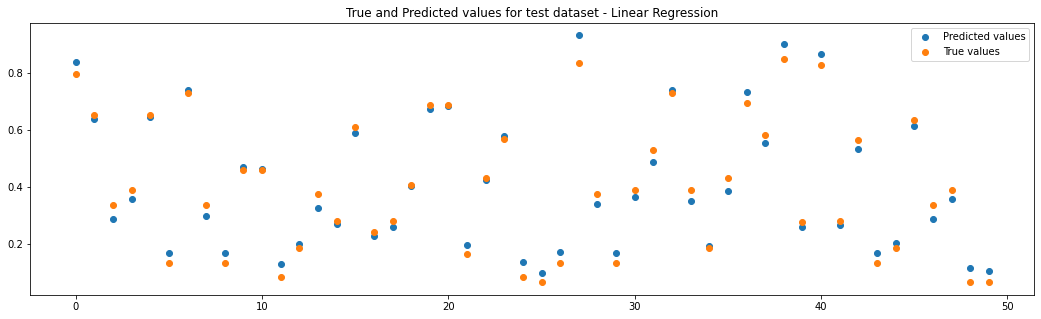

Root Mean Squared Error: [0.03635414]
Mean Absolute Error [0.03058606]
Mean Absolute Percentage Error [18.38564129]


In [ ]:
lin_reg_model_metrics = view_metrics(y_test, lin_reg_model_predictions,'Linear Regression', samples = 50, total_samples=2000)
## If predicted value is same as true value, the points will be overlapping. Closer the points, better is the prediction.

### Random Forest Regressor Model

In [ ]:
rand_forest_model = RandomForestRegressor(max_depth=5, random_state=0) # build model
rand_forest_model = rand_forest_model.fit(x_train, y_train.values.ravel()) # train model
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
feature_importance = rand_forest_model.feature_importances_
R2 = rand_forest_model.score(x_train, y_train) # coefficient of determination
rand_forest_model_predictions = rand_forest_model.predict(x_test) # make predictions

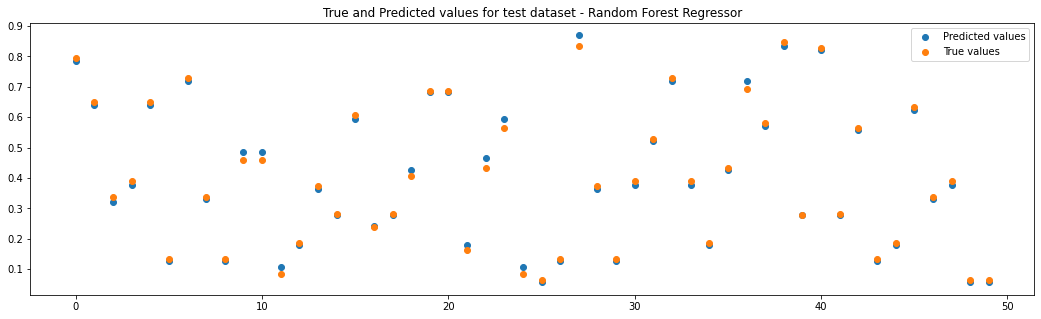

Root Mean Squared Error: [0.01435106]
Mean Absolute Error [0.01130096]
Mean Absolute Percentage Error [5.38884231]


In [ ]:
rand_forest_model_metrics = view_metrics(y_test, rand_forest_model_predictions,'Random Forest Regressor', samples = 50, total_samples=2000)

### Neural Network Regression Model

In [ ]:
nn_model = MLPRegressor(hidden_layer_sizes=(10,4),
                                    activation='relu', # activation function in the nodes of the neral net
                                    solver='adam', # optimizer algorithm
                                    learning_rate='constant',
                                    learning_rate_init=0.001, # initial learning rate
                                    max_iter=300, # max iterations to train for
                                    tol = -1, # tolerance for when to stop training should be range 0.001 to 0.0000001, -1 for max_iter
                                    shuffle=True,
                                    verbose=True) # show details at each iteration
nn_model = nn_model.fit(x_train, y_train.values.ravel())

Iteration 1, loss = 0.48593957
Iteration 2, loss = 0.15456463
Iteration 3, loss = 0.03148729
Iteration 4, loss = 0.01695521
Iteration 5, loss = 0.01309911
Iteration 6, loss = 0.01059623
Iteration 7, loss = 0.00871059
Iteration 8, loss = 0.00720560
Iteration 9, loss = 0.00599467
Iteration 10, loss = 0.00501200
Iteration 11, loss = 0.00420532
Iteration 12, loss = 0.00348485
Iteration 13, loss = 0.00279033
Iteration 14, loss = 0.00228514
Iteration 15, loss = 0.00191525
Iteration 16, loss = 0.00164745
Iteration 17, loss = 0.00145009
Iteration 18, loss = 0.00130413
Iteration 19, loss = 0.00120139
Iteration 20, loss = 0.00112262
Iteration 21, loss = 0.00107050
Iteration 22, loss = 0.00102834
Iteration 23, loss = 0.00099642
Iteration 24, loss = 0.00096831
Iteration 25, loss = 0.00094729
Iteration 26, loss = 0.00092649
Iteration 27, loss = 0.00090193
Iteration 28, loss = 0.00088343
Iteration 29, loss = 0.00086459
Iteration 30, loss = 0.00084713
Iteration 31, loss = 0.00082928
Iteration 32, los

In [ ]:
nn_model_predictions = nn_model.predict(x_test)

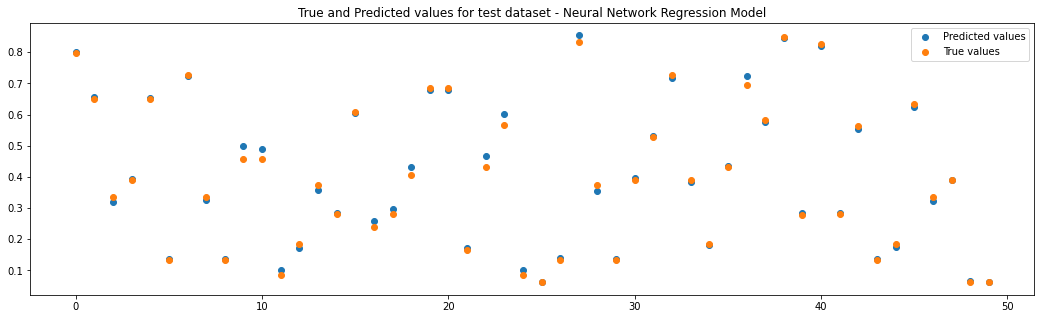

Root Mean Squared Error: [0.01568036]
Mean Absolute Error [0.01178104]
Mean Absolute Percentage Error [5.74633837]


In [ ]:
nn_model_metrics = view_metrics(y_test, nn_model_predictions,'Neural Network Regression Model', samples = 50, total_samples=2000)

## Comparing model performances

In [ ]:
print("%10s | %7s | %7s | %7s" % ('MODEL', 'RMSE', 'MAE', 'MAPE'))
print('___________________________________________')
for name,metrics in zip(['LIN_REG','RAND_FRST','NN'],[lin_reg_model_metrics, rand_forest_model_metrics, nn_model_metrics]):
    print ("%10s | %.5f | %.5f | %.5f %%" % (name, metrics[0][0], metrics[1][0], metrics[2][0]))
print()
print('Note: Lower values are better')

     MODEL |    RMSE |     MAE |    MAPE
___________________________________________
   LIN_REG | 0.03635 | 0.03059 | 18.38564 %
 RAND_FRST | 0.01435 | 0.01130 | 5.38884 %
        NN | 0.01568 | 0.01178 | 5.74634 %

Note: Lower values are better


## Predicting interest rates

In [ ]:
def get_interest_rate(model, features):
    return (model.predict(features))*(max_rate-min_rate) + min_rate

In [ ]:
sample = x_test[2:3] # substitute with the input you want to predict the rate for
interest_rate = get_interest_rate(rand_forest_model, sample)
print('Predicted interest rate is:', interest_rate)
print('for the following user profile:')
sample

Predicted interest rate is: [11.44435391]
for the following user profile:


,loan_amnt,term,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,loan_status_Binary
2048,0.117647,1.0,0.069723,0.166667,0.205882,0.545455,0.0,0.043919,0.0,0.666667,0.204545,0.261029,0.0,0.0,0.0


### Saving the models

In [ ]:
# this cell may take a few seconds to execute depending on model size

# for saving models
import pickle
# import _pickle as cPickle # try this if previous import fails

model_name = 'best_model.model'
pickle.dump(rand_forest_model, open(model_name, 'wb'))